In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from losses import _reconstruction_loss
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, Attributer
from utils import tuple_L1Loss
from pytorch_wavelets import DTCWTForward, DTCWTInverse, DWTForward, DWTInverse
import pywt

## load data and model

In [2]:
# get dataloader and model
train_loader, model = load_dataloader_and_pretrained_model(p)

## interp score & optimize wavelet

In [54]:
# input
torch.manual_seed(p.seed)
im = iter(train_loader).next()[0][0:64].to(device)
im.requires_grad = True

# wavelet transform with initialization
wt = Wavelet_Transform(J=3)

# prepend transformation onto network
mt = TrimModel(model, wt.inverse)

# attributer
attr_methods = 'InputXGradient'
attributer = Attributer(mt, attr_methods=attr_methods)

In [55]:
# optimization params
losses = []
num_epochs = 100
lamb = 100

params = list(wt.xfm.parameters()) + list(wt.ifm.parameters())
optimizer = torch.optim.SGD(params, lr=0.0000000005)

# Training Loop
# Lists to keep track of progress
init_losses = [torch.norm(wt.inverse(wt(im)) - im)**2, tuple_L1Loss(attributer(wt(im), target=1))]
print("Initial values: recon={:.3f} and l1loss={:.3f}".format(init_losses[0], init_losses[1]))
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # zero grad
    optimizer.zero_grad()    
    # loss
    im_t = wt(im)
    reconstruction = wt.inverse(im_t)
    attributions = attributer(im_t, target=1)
    loss = lamb*torch.norm(im - reconstruction)**2 + tuple_L1Loss(attributions)
    # backward
    loss.backward()
    # Update step
    optimizer.step()
    
    losses.append(loss.data.item())
    print('\rIteration: {}/{}'.format(epoch+1, num_epochs), end='')

final_losses = [torch.norm(wt.inverse(wt(im)) - im)**2, tuple_L1Loss(attributer(wt(im), target=1))]
print("\nFinal values: recon={:.3f} and l1loss={:.3f}".format(final_losses[0], final_losses[1]))    

Initial values: recon=0.000 and l1loss=65.414
Starting Training Loop...
Iteration: 100/100
Final values: recon=0.000 and l1loss=65.414


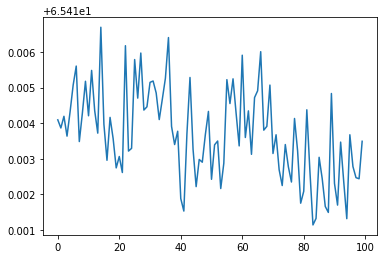

In [56]:
plt.plot(losses)